# Monkey Functions
- 1.) Make pipeline for predictions
- 2.) Cycle through all the features and make predictions 
- 3.) Make software that allows for the user to enter the following and get preditctions out of it (i.e. train on all data and get novel predictions - dramatic presentation)
    - Age
    - Sex
    - Dose
    - Time since Irradiation
- 4.) Incorporate optimization in the pipeline
- 5.) Pipeline for health outcomes
    - able to cycle through as well

In [21]:
### Using monkey_env/ ###
### If giving a tqb error, run this code twice###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

import catboost as cb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings("ignore")

print("Setup Complete")


Setup Complete


In [2]:
pwd

'/Users/aidanlew/Desktop/cmb/codes/monkey_irrad_sept-2022'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Predicting Biomarker Levels and Health Outcomes

## Data loading

In [5]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
#minhealth_monkey_df.head(15)
minhealth_monkey_df.columns


Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

In [6]:
# See our monkey sample size
print('Total Monkeys:{}'.format(minhealth_monkey_df['ID'].nunique()))
 
# Count the control monkeys
print('Non-Irradiated Monkeys:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[0]))
 
# Count the irradiated monkeys
#print('Irradiated Samples:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[!=0]))



Total Monkeys:152
Non-Irradiated Monkeys:32


In [7]:
#Makee a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [8]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [9]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


# PLOTTING FUNCTION 

In [35]:
def predict_and_plot(model, X_validation, y_validation, y):
    
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )

    
    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    #print('MSE: {}'.format(mean_squared_error(y_validation, a_df)))

# MODEL FUCTION

In [12]:
def regression_model_formation (X,y,cat_features):
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

# MODEL, PREDICT, AND PLOT FXN

In [13]:
def model_pred_plot (X, y, cat_features, X_validation, y_validation):
    ### Model Formation ###
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    ### Plotting ###
    
    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    plt.show()
    print('MSE: {}'.format(mean_squared_error(y_validation, a_df)))

# DATA SETUP FUNCTION

In [14]:
def data_setup (df):
  ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    global X, y, ylabel
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    global cat_features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    global pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data
    
    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    
    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )


# PIPELINE FOR REGRESSION


In [15]:
def regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X_train, y_train,
              cat_features=cat_features,
              verbose=False
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

   
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    
    plt.show() 
    print('MSE: {}'.format(mean_squared_error(y_validation, a_df)))
    
    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    

# HEALTH OUTCOME PIPELINE

In [15]:
def classifier_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostClassifier(iterations=iterations, 
                              learning_rate=learning_rate,
                               loss_function='Logloss',
                               custom_loss=['AUC','Accuracy'],
                               early_stopping_rounds= early_stopping_rounds
    )
   

    model.fit(X_train, y_train, 
              cat_features=cat_features, 
              verbose=False  
    )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

    ### Plotting ###
    # make confusion matrix
    cm = confusion_matrix(y_validation, a_df)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  #display_labels=clf.classes_
                                 )
    
    disp.plot()
    plt.grid(False)


    Accuracy = metrics.accuracy_score(y_validation, a_df)
    Precision = metrics.precision_score(y_validation, a_df)

    print('Accuracy:',Accuracy, 'Precision:',Precision)
    print(classification_report(y_validation, a_df))

# OPTOMIZED REGRESSION

In [16]:
def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        #"iterations" : trial.suggest_int("iterations", 1, 100000),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostRegressor(**param)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_validation, y_validation)], verbose=0, early_stopping_rounds=100)

    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    accuracy = r2_score(y_validation, a)
    return accuracy


In [17]:
def opomized_regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    data_setup(df)
    
    opq = int(input('Do you want this potomized? (1/0)'))
    
    if opq == 1:
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50, timeout=600)
        trial = study.best_trial
        
        model = CatBoostRegressor(**trial.params)
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
        
        predict_and_plot(model, X_validation, y_validation, y)
        
    else: 
        ### Model Formation ###
        iterations = float(input('Iterations:'))
        learning_rate = float(input('Learning Rate:'))
        early_stopping_rounds = float(input('Stopping Rounds:'))

        model = CatBoostRegressor(iterations=iterations, 
                                  learning_rate=learning_rate,
                                   early_stopping_rounds= early_stopping_rounds
                                 )
        model.fit(X_train, y_train,
                  cat_features=cat_features,
                  verbose=False
             )

        predict_and_plot(model, X_validation, y_validation, y)

# Single Monkey Preditions, whole data

In [18]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df

#Exclude datetime feautres
sreg_df=sreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
sreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,Yes,F,Clinical,1303.0,43.0,81.0,1.14,10.3,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,Yes,F,Clinical,1344.0,44.0,81.0,1.14,10.4,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


In [ ]:
regression_pipeline (sreg_df)

In [ ]:
# Optuna doesn't work with such small sampling
opomized_regression_pipeline (sreg_df)

# Multi Monkey Predictions, whole data

In [39]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df

#Exclude datetime feautres
mreg_df=mreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
mreg_df.head(5)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.9,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.3,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.6,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 10
Learning Rate: 0.5
Stopping Rounds: 5
Plot Title: t


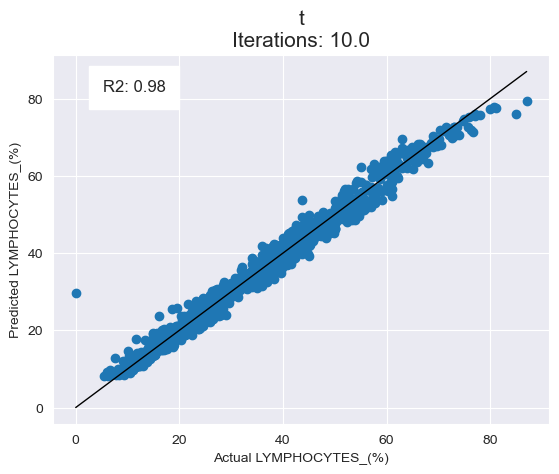

                                           Feature Id  Importances
0                                            NEUT_(%)    86.651296
1                                     ABS_LYMPH_(/uL)     5.056368
2                                      ABS_MONO_(/uL)     2.967779
3                                       ABS_EOS_(/uL)     1.682345
4                                            MONO_(%)     1.554043
5                                             EOS_(%)     0.890583
6                                                 SEX     0.414483
7                                                 AGE     0.265342
8                                PLATLET_COUNT_(K/uL)     0.185069
9                                    Hemocrit_(HCT_%)     0.169562
10                                           BASO_(%)     0.045291
11                                    MONTHS AT IRRAD     0.036440
12                                          DOSE_(Gy)     0.025406
13                                     ABS_NEUT_(/uL)     0.02

In [95]:
regression_pipeline(mreg_df)


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4
Test Size 0.3
Do you want this potomized? (1/0) 1
Plot Title: optomized


                                           Feature Id  Importances
0                                            NEUT_(%)    48.983695
1                                     ABS_LYMPH_(/uL)    19.646744
2                                      ABS_NEUT_(/uL)    18.187191
3                                          WBC_(K/uL)     2.941341
4                                             EOS_(%)     1.456191
5                                       ABS_EOS_(/uL)     1.365070
6                                      ABS_MONO_(/uL)     1.011283
7                                    DAYS_SINCE_IRRAD     0.843320
8                                            MONO_(%)     0.693983
9                                                 AGE     0.589995
10                                   Hemocrit_(HCT_%)     0.587295
11                                           BASO_(%)     0.495831
12                                 MONTHS_SINCE_IRRAD     0.482448
13                               PLATLET_COUNT_(K/uL)     0.48

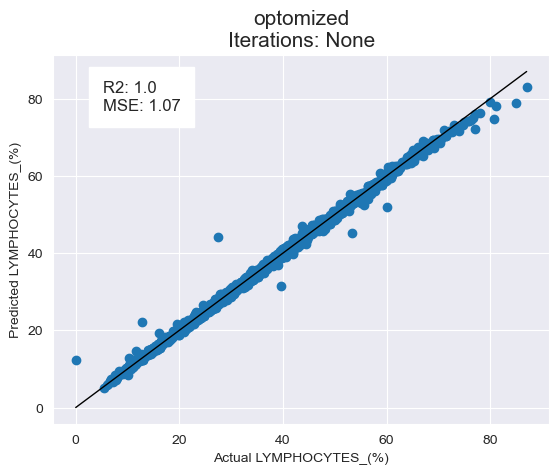

In [40]:
opomized_regression_pipeline (mreg_df)

## Prediction of biomarkers

### A. Predictions using only the top 5 important features
top 5 features found in section 1.a. Using the top 5 features found from each model (single v. multi monkey)

#### Single Monkey:
Top 5 features: 
- 0 NEUT_(%)	26.502043
- 1	TYPE	12.952220
- 2	ABS_LYMPH_(/uL)	12.820068
- 3	EOS_(%)	11.754037
- 4	RBC_(M/uL)	11.554449


In [ ]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'TYPE', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)', 'LYMPHOCYTES_(%)']]
regression_pipeline(sred_reg_df)

#### Multi Monkey
Top 5 features:
- 0 NEUT_(%)	92.324836
- 1	ABS_LYMPH_(/uL)	3.185803
- 2	ABS_MONO_(/uL)	2.682848
-  3	EOS_(%)	1.198216
- 4	Hemaglobin_(HGB_g/dL)	0.559005

Also try with just NEUT_(%) since it is so heavily weighted

In [64]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'ABS_MONO_(/uL)', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]


#regression_pipeline(mred_reg_df)


### B. Predicting lymphocytes with only the irradiation data


#### Multi Monkey only
No variation for single monkey model formation

In [66]:
mred_reg_df

,ID,ABS_MONO_(/uL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),Hemaglobin_(HGB_g/dL),LYMPHOCYTES_(%)
0,2061,818,43.5,5232,0.9,12.0,48.0
1,2061,396,74.0,1883,0.1,10.5,21.4
2,2061,595,87.9,1488,0.1,10.5,8.5
3,2061,570,91.7,1161,0.1,10.4,5.5
4,2061,759,78.8,1668,0.1,8.4,14.5
...,...,...,...,...,...,...,...
4547,2112,409,25.7,4422,1.1,11.7,67.0
4548,2112,359,33.3,2210,1.5,12.4,56.1
4549,2210,640,59.7,1394,1.2,13.0,26.8
4550,2210,632,51.2,2100,1.7,13.2,36.2


In [67]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mrad_reg_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]


#regression_pipeline(mrad_reg_df)


#### single monkey only

In [68]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
srad_reg_df = single_minbio_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
srad_reg_df.tail(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
49,2046,Yes,F,2570.0,84.0,81.0,1.14,13.8,58.3
50,2046,Yes,F,2738.0,90.0,81.0,1.14,14.3,52.8


## Predictions of the health outcomes
Doesn't make sense to predict or use single monkey moels/data becuase there is only one observation per monkey

In [97]:
minhealth_monkey_df.head(2)

,ID,Time_Under_Observation_(yrs),Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Animal_Status,Diabetes_(Y/N),Cataracts_(Y/N),Arthritis_(Y/N),...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,1423,1.380822,0.0,NaN,NaN,9.947945,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,11.868493,0.0,NaN,NaN,19.276712,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0


### A. Multi Monkey using only top 5 features
- 0. Dose_(Gy)	14.984810
- 1	Heart_(Y/N)	14.908153
- 2	Time_Under_Observation_(yrs)	13.851867
- 3	Overweight_(Y/N)	11.484527
- 4	Years_Since_Irrad	11.038610

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 100000
Learning Rate: 0.5
Stopping Rounds: 100000


Accuracy: 0.782608695652174 Precision: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        37
           1       0.33      0.11      0.17         9

    accuracy                           0.78        46
   macro avg       0.57      0.53      0.52        46
weighted avg       0.72      0.78      0.74        46



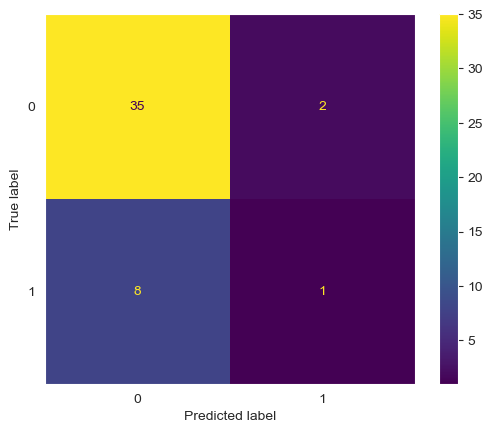

In [115]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]

classifier_pipeline (five_health_df)

### B. Multi monkey with only the radiation data

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 100
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 0.6956521739130435 Precision: 0.0
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        37
           1       0.00      0.00      0.00         9

    accuracy                           0.70        46
   macro avg       0.39      0.43      0.41        46
weighted avg       0.63      0.70      0.66        46



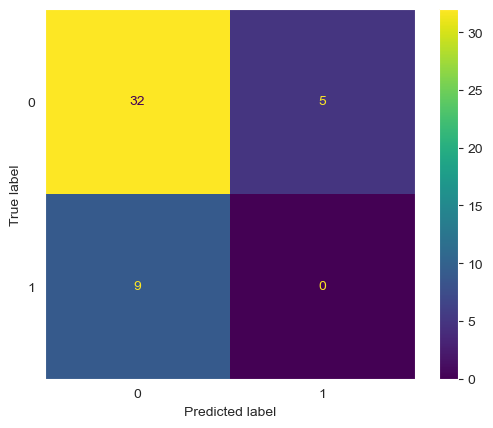

In [101]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]

classifier_pipeline (rad_health_df)

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 1000


Accuracy: 0.8043478260869565 Precision: 0.5
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        37
           1       0.50      0.33      0.40         9

    accuracy                           0.80        46
   macro avg       0.68      0.63      0.64        46
weighted avg       0.78      0.80      0.79        46



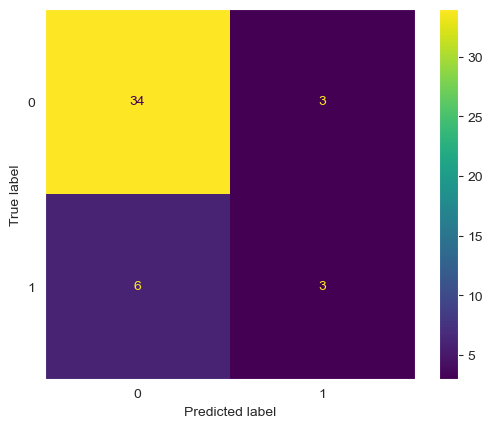

In [106]:
minhealth_monkey_df.head()

classifier_pipeline (minhealth_monkey_df)

## Predicting dose 

In [73]:
#make single monkey
single_minbio_df.copy()
single_dose_df = single_minbio_df

#fill na values to 0
single_dose_df[['DOSE_(Gy)']]= single_dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)



#make multi monkey df
minbio_monkey_df.copy()
dose_df = minbio_monkey_df

#fill na values to 0
dose_df[['DOSE_(Gy)']]= dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)

dose_df['DOSE_(Gy)']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64

In [74]:
dose_df = dose_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)

In [ ]:
regression_pipeline(dose_df)

# Cycle through the different features

# REGRESSION CYCLER

In [18]:
def cycle_feature_regression_predictions (df):
    
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)

            #declare catagorical features
            cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

            #put data into pool
            pool = Pool(data=X, label=y, cat_features=cat_features)

            #train tesr split
            #test_size = float(input('Test Size'))
            test_size = 0.3
            data= train_test_split(X, y, test_size=test_size, random_state=0)

            #The order of this matters#
            X_train, X_validation, y_train, y_validation= data

            train_pool = Pool(
                data = X_train,
                label = y_train,
                cat_features = cat_features
            )


            validation_pool = Pool(
                data = X_validation,
                label = y_validation,
                cat_features = cat_features
            )

            ### Model Formation ###
            #iterations = float(input('Iterations:'))
            #learning_rate = float(input('Learning Rate:'))
            #early_stopping_rounds = float(input('Stopping Rounds:'))
            iterations = 10
            learning_rate = 0.5
            early_stopping_rounds = 2


            model = CatBoostRegressor(iterations=iterations, 
                                      learning_rate=learning_rate,
                                       early_stopping_rounds= early_stopping_rounds
                                     )
            model.fit(X_train,y_train,
                      cat_features=cat_features,
                      verbose=False
                 )

            ### Predictions ###
            a = model.predict(X_validation)
            a_df = pd.DataFrame(a)


            ### Plotting ###
            # Plot the predictions
            fig, ax = plt.subplots()
            ax.scatter(y_validation, a_df)

            ax.plot([y.min(), y.max()], [y.min(), y.max()], 
                    'k-', 
                    linewidth=1, 
                    markersize=120
            )

            #Plot axis titles
            ax.set_xlabel('Actual {}'.format(str(ylabel)))
            ax.set_ylabel('Predicted {}'.format(str(ylabel)))

            #Title of the plot
            #plot_title = input("Plot Title:")
            show_iters = model.get_param('iterations')  
            ax.set_title(ylabel + "\nIterations: {}".format(str(show_iters))
                         ,fontsize=15
            )

            #cordinates for the R2 value box
            xmin, xmax, ymin, ymax = plt.axis()
            yrange = ymax-ymin
            xrange = xmax-xmin


            #Plotting the R2 score and MSE
            ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
            )
    

            plt.show() 

            ### Feature Importance ###

            feat = model.get_feature_importance(data=pool,
                               prettified=True,

            )

            print(feat)


In [79]:
def facet (df):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Biomarker Predictions", fontsize=18, y=0.95)

    # set number of columns (use 3 to demonstrate the change)
    ncols = 6

    # calculate number of rows
    #nrows = len(tickers) // ncols + (len(tickers) % ncols > 0)
    nrows = 5
    n = 0 
   



    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = 4#int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:        
            n=n+1
            # add a new subplot iteratively using nrows and cols
            
            
            ax = plt.subplot(nrows, ncols, n+1 )
            ax.scatter(df[columnName],df[columnName])

    

            # filter df and plot ticker on the new subplot axis
            df[columnName].plot(ax=ax)

            # chart formatting
            ax.set_title(columnName.upper())
            #ax.get_legend().remove()
            ax.set_xlabel("")

In [ ]:
facet (cyclebio_df)

In [20]:
### make a parent df
minbio_monkey_df.copy()
cyclebio_df = minbio_monkey_df

#Exclude datetime feautres
cyclebio_df=cyclebio_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
cyclebio_df['DOSE_(Gy)'] = cyclebio_df['DOSE_(Gy)'].fillna(0)
cyclebio_df.head(2)

,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,0.0,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,0.0,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


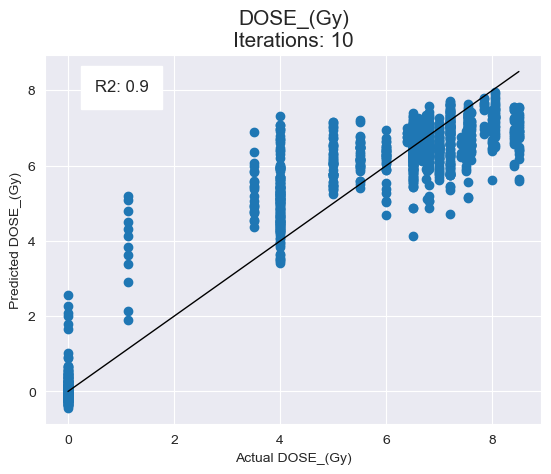

                                           Feature Id  Importances
0                                  MONTHS_SINCE_IRRAD    76.074829
1                                     MONTHS AT IRRAD    10.667901
2                                                 SEX     2.868666
3                                    DAYS_SINCE_IRRAD     2.650059
4                                          RBC_(M/uL)     1.545309
5                                                 AGE     1.384343
6                    Mean_corpuscular_volume_(MCV_fL)     0.745017
7                                    Hemocrit_(HCT_%)     0.733612
8                                          WBC_(K/uL)     0.575188
9                                             Species     0.498999
10               Mean_corpuscular_hemaglobin_(MCH_pg)     0.481430
11                               PLATLET_COUNT_(K/uL)     0.476495
12                                            EOS_(%)     0.303699
13                                    LYMPHOCYTES_(%)     0.26

iteritems is deprecated and will be removed in a future version. Use .items instead.


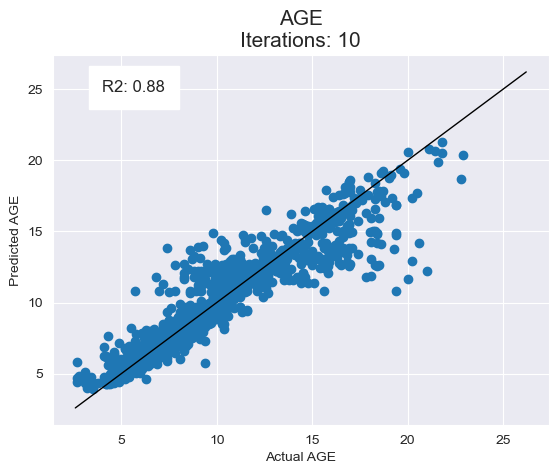

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    39.293472
1                                  MONTHS_SINCE_IRRAD    25.858496
2                                             Species    10.640765
3                                           DOSE_(Gy)     8.251663
4                                    DAYS_SINCE_IRRAD     5.824371
5                                                 SEX     3.273704
6                                          RBC_(M/uL)     1.550351
7                                            MONO_(%)     1.220007
8                                          WBC_(K/uL)     1.067296
9                                    Hemocrit_(HCT_%)     1.012866
10                   Mean_corpuscular_volume_(MCV_fL)     0.493303
11                                    ABS_LYMPH_(/uL)     0.397368
12                               PLATLET_COUNT_(K/uL)     0.380984
13                                     ABS_MONO_(/uL)     0.32

iteritems is deprecated and will be removed in a future version. Use .items instead.


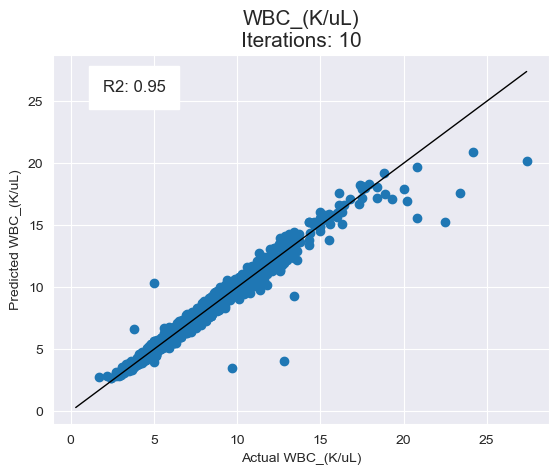

                                           Feature Id  Importances
0                                      ABS_NEUT_(/uL)    66.229707
1                                     ABS_LYMPH_(/uL)    28.968441
2                                      ABS_MONO_(/uL)     2.375298
3                                       ABS_EOS_(/uL)     0.850547
4                                                 AGE     0.566350
5                                     LYMPHOCYTES_(%)     0.411529
6                    Mean_corpuscular_volume_(MCV_fL)     0.294307
7                                      ABS_BASO_(/uL)     0.082674
8                                          RBC_(M/uL)     0.063607
9                               Hemaglobin_(HGB_g/dL)     0.051200
10                                          DOSE_(Gy)     0.042938
11                                 MONTHS_SINCE_IRRAD     0.035826
12                                           MONO_(%)     0.027575
13                                            Species     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


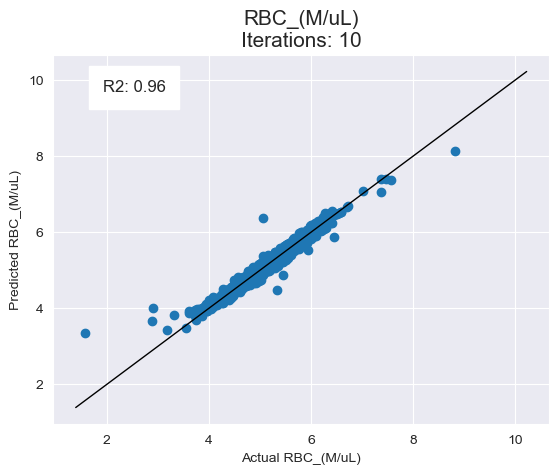

                                           Feature Id  Importances
0                                    Hemocrit_(HCT_%)    58.258033
1                    Mean_corpuscular_volume_(MCV_fL)    27.277220
2                               Hemaglobin_(HGB_g/dL)    11.902579
3                Mean_corpuscular_hemaglobin_(MCH_pg)     1.504498
4                                                 AGE     0.481790
5                                     MONTHS AT IRRAD     0.173787
6                                           DOSE_(Gy)     0.150863
7                                  MONTHS_SINCE_IRRAD     0.126474
8   Mean_corpuscular_hemaglobin_concentration_(MCH...     0.080481
9                                PLATLET_COUNT_(K/uL)     0.044273
10                                            Species     0.000000
11                                              IRRAD     0.000000
12                                                SEX     0.000000
13                                               TYPE     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


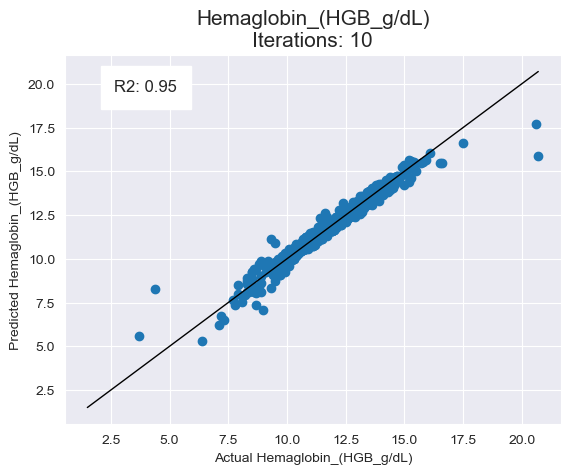

                                           Feature Id  Importances
0                                    Hemocrit_(HCT_%)    70.994125
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    21.304072
2                                          RBC_(M/uL)     2.186785
3                                                 SEX     1.754444
4                                            BASO_(%)     1.197905
5                    Mean_corpuscular_volume_(MCV_fL)     0.893001
6                Mean_corpuscular_hemaglobin_(MCH_pg)     0.578384
7                                  MONTHS_SINCE_IRRAD     0.359890
8                                PLATLET_COUNT_(K/uL)     0.309319
9                                       ABS_EOS_(/uL)     0.132411
10                                                AGE     0.128884
11                                     ABS_MONO_(/uL)     0.114173
12                                           MONO_(%)     0.046608
13                                            Species     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


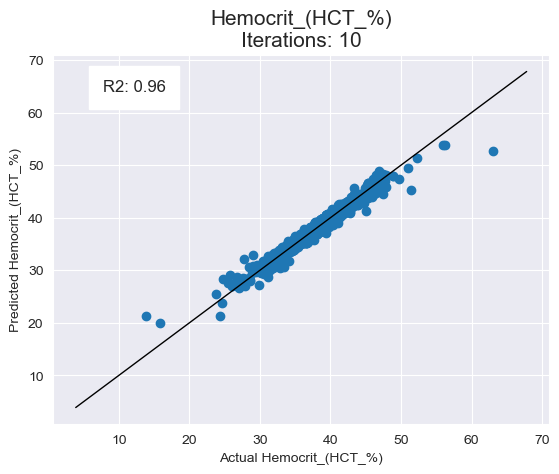

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    71.263276
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    15.124545
2                                          RBC_(M/uL)     7.820592
3                    Mean_corpuscular_volume_(MCV_fL)     2.881744
4                                PLATLET_COUNT_(K/uL)     0.828758
5                                                 SEX     0.658082
6                                                 AGE     0.609528
7                                            BASO_(%)     0.550021
8                                           DOSE_(Gy)     0.101845
9                                       ABS_EOS_(/uL)     0.079383
10                                 MONTHS_SINCE_IRRAD     0.037618
11                                    ABS_LYMPH_(/uL)     0.019604
12                                           MONO_(%)     0.013319
13                                     ABS_MONO_(/uL)     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


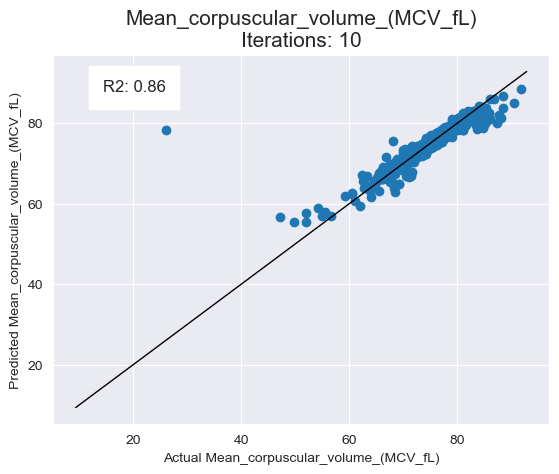

                                           Feature Id  Importances
0                Mean_corpuscular_hemaglobin_(MCH_pg)    54.022795
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    38.799299
2                               Hemaglobin_(HGB_g/dL)     3.959639
3                                    Hemocrit_(HCT_%)     1.738812
4                                                 SEX     0.970388
5                                          RBC_(M/uL)     0.314405
6                                            MONO_(%)     0.064679
7                                     LYMPHOCYTES_(%)     0.029930
8                                                 AGE     0.020618
9                                       ABS_EOS_(/uL)     0.015377
10                                         WBC_(K/uL)     0.012524
11                                           NEUT_(%)     0.012177
12                                   DAYS_SINCE_IRRAD     0.011011
13                                 MONTHS_SINCE_IRRAD     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


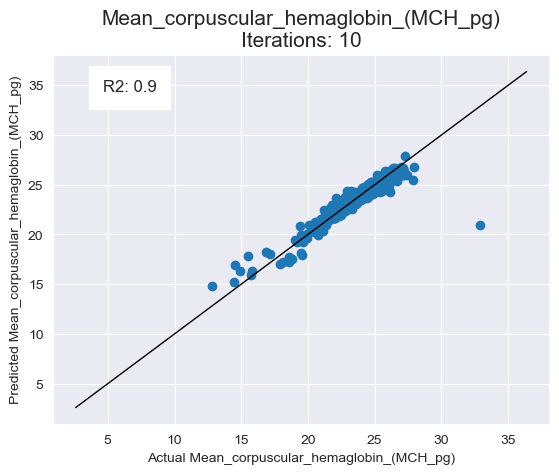

                                           Feature Id  Importances
0                    Mean_corpuscular_volume_(MCV_fL)    62.520891
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    33.445423
2                                                 SEX     1.255391
3                               Hemaglobin_(HGB_g/dL)     0.931187
4                                                 AGE     0.553176
5                                       ABS_EOS_(/uL)     0.326469
6                                          WBC_(K/uL)     0.234528
7                                    Hemocrit_(HCT_%)     0.228921
8                                     ABS_LYMPH_(/uL)     0.226191
9                                  MONTHS_SINCE_IRRAD     0.140321
10                                           MONO_(%)     0.040940
11                                    MONTHS AT IRRAD     0.037404
12                               PLATLET_COUNT_(K/uL)     0.020629
13                                     ABS_NEUT_(/uL)     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


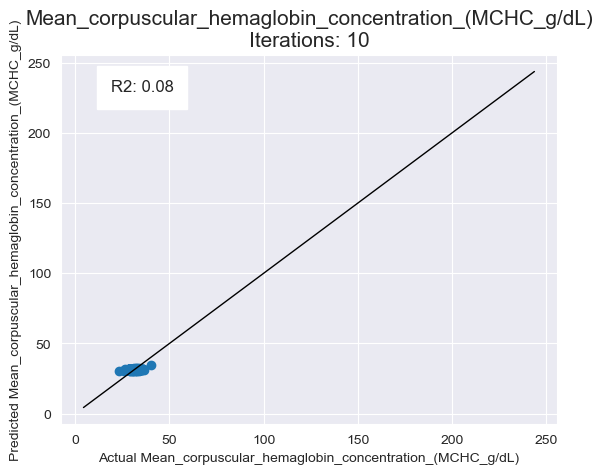

                              Feature Id  Importances
0                       Hemocrit_(HCT_%)    90.990398
1                                    SEX     1.817841
2                  Hemaglobin_(HGB_g/dL)     1.752471
3                                    AGE     0.731622
4                        LYMPHOCYTES_(%)     0.671202
5                              DOSE_(Gy)     0.634096
6                          ABS_EOS_(/uL)     0.622983
7                         ABS_BASO_(/uL)     0.544964
8                        ABS_LYMPH_(/uL)     0.438901
9                     MONTHS_SINCE_IRRAD     0.407637
10                               EOS_(%)     0.361734
11                            RBC_(M/uL)     0.308316
12                        ABS_NEUT_(/uL)     0.176965
13                              MONO_(%)     0.165565
14                       MONTHS AT IRRAD     0.140232
15                      DAYS_SINCE_IRRAD     0.095509
16                              NEUT_(%)     0.085663
17                          

iteritems is deprecated and will be removed in a future version. Use .items instead.


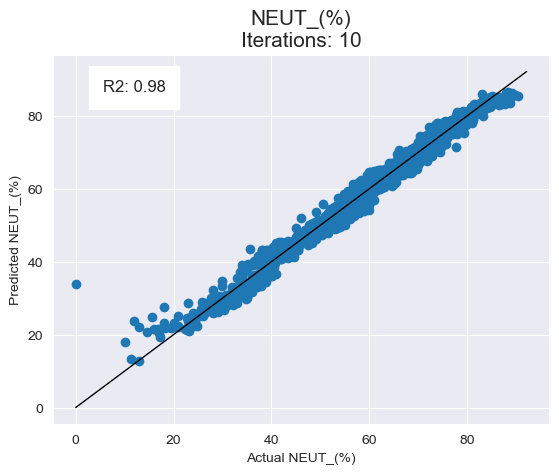

                                           Feature Id  Importances
0                                     LYMPHOCYTES_(%)    89.775261
1                                            MONO_(%)     4.796650
2                                             EOS_(%)     3.015310
3                                      ABS_NEUT_(/uL)     1.005307
4                                            BASO_(%)     0.384792
5                                       ABS_EOS_(/uL)     0.352237
6                                                 SEX     0.218568
7                                                 AGE     0.148345
8                                    Hemocrit_(HCT_%)     0.140073
9                                      ABS_BASO_(/uL)     0.069089
10                                    ABS_LYMPH_(/uL)     0.035784
11                                 MONTHS_SINCE_IRRAD     0.027297
12                                          DOSE_(Gy)     0.013582
13                                   DAYS_SINCE_IRRAD     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


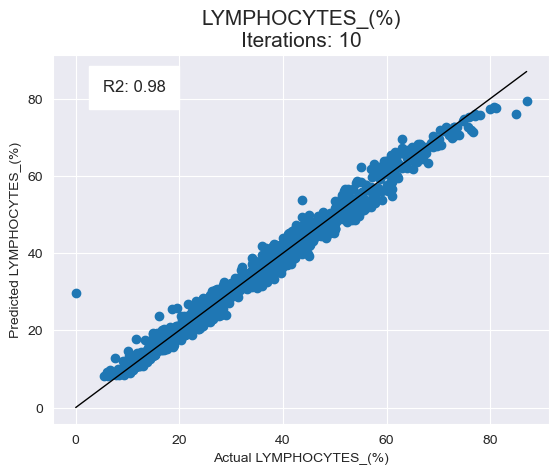

                                           Feature Id  Importances
0                                            NEUT_(%)    86.651296
1                                     ABS_LYMPH_(/uL)     5.056368
2                                      ABS_MONO_(/uL)     2.967779
3                                       ABS_EOS_(/uL)     1.682345
4                                            MONO_(%)     1.554043
5                                             EOS_(%)     0.890583
6                                                 SEX     0.414483
7                                                 AGE     0.265342
8                                PLATLET_COUNT_(K/uL)     0.185069
9                                    Hemocrit_(HCT_%)     0.169562
10                                           BASO_(%)     0.045291
11                                    MONTHS AT IRRAD     0.036440
12                                          DOSE_(Gy)     0.025406
13                                     ABS_NEUT_(/uL)     0.02

iteritems is deprecated and will be removed in a future version. Use .items instead.


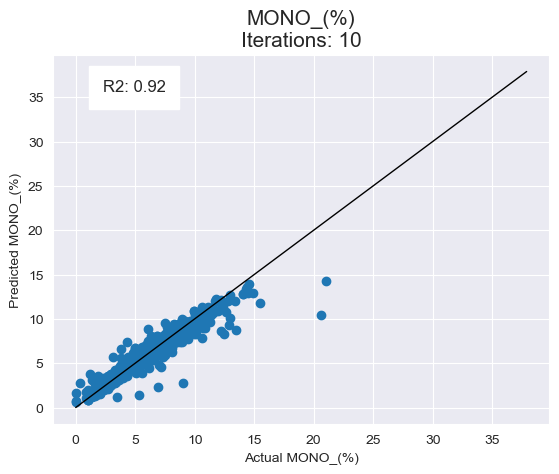

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    59.724366
1                                          WBC_(K/uL)    39.336514
2                                    Hemocrit_(HCT_%)     0.250661
3                                                 AGE     0.170014
4                                            NEUT_(%)     0.159809
5                                  MONTHS_SINCE_IRRAD     0.067147
6                                      ABS_BASO_(/uL)     0.066357
7                                    DAYS_SINCE_IRRAD     0.065720
8                                PLATLET_COUNT_(K/uL)     0.032615
9                                     ABS_LYMPH_(/uL)     0.028619
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.024847
11                                            EOS_(%)     0.023838
12                                      ABS_EOS_(/uL)     0.015708
13                              Hemaglobin_(HGB_g/dL)     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


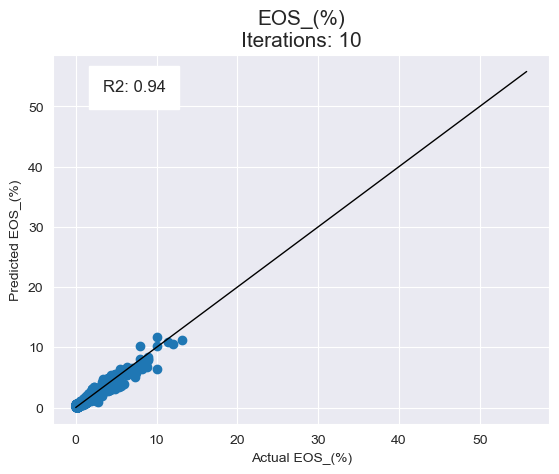

                                           Feature Id  Importances
0                                       ABS_EOS_(/uL)    82.394682
1                                          WBC_(K/uL)    13.031707
2                                            NEUT_(%)     2.037545
3                                      ABS_NEUT_(/uL)     0.509648
4                                  MONTHS_SINCE_IRRAD     0.441245
5                                                 AGE     0.381904
6   Mean_corpuscular_hemaglobin_concentration_(MCH...     0.286361
7                                    Hemocrit_(HCT_%)     0.218592
8                                     MONTHS AT IRRAD     0.174330
9                                    DAYS_SINCE_IRRAD     0.171287
10                                    LYMPHOCYTES_(%)     0.124324
11                                           BASO_(%)     0.104443
12                   Mean_corpuscular_volume_(MCV_fL)     0.076084
13                                           MONO_(%)     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


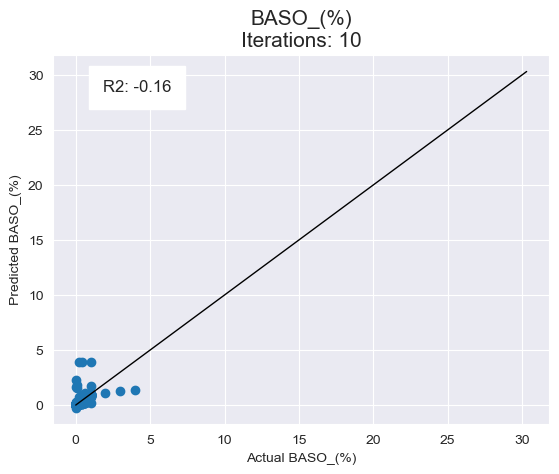

                                           Feature Id  Importances
0                                      ABS_BASO_(/uL)    28.845148
1                Mean_corpuscular_hemaglobin_(MCH_pg)    21.810585
2                                            NEUT_(%)    13.460284
3                                      ABS_NEUT_(/uL)    10.294166
4                                             EOS_(%)     5.295656
5                                          WBC_(K/uL)     4.521729
6                                            MONO_(%)     4.483600
7                                     ABS_LYMPH_(/uL)     3.047034
8                                  MONTHS_SINCE_IRRAD     2.557720
9                                                 AGE     1.750123
10                                    LYMPHOCYTES_(%)     1.664542
11                                      ABS_EOS_(/uL)     1.418716
12                                    MONTHS AT IRRAD     0.565318
13                                   Hemocrit_(HCT_%)     0.06

iteritems is deprecated and will be removed in a future version. Use .items instead.


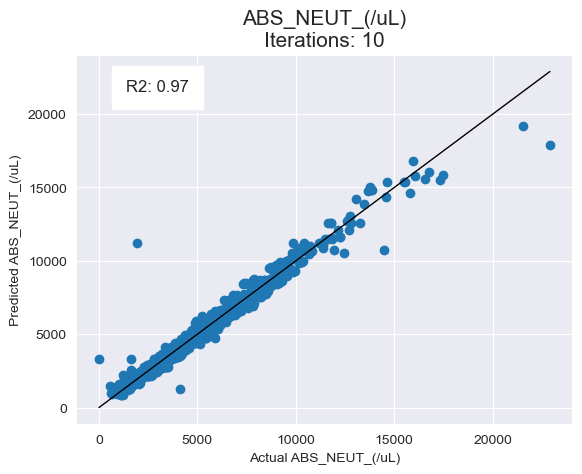

                                           Feature Id  Importances
0                                          WBC_(K/uL)    61.429197
1                                            NEUT_(%)    35.030449
2                                     LYMPHOCYTES_(%)     2.311107
3                                    Hemocrit_(HCT_%)     0.286675
4                                       ABS_EOS_(/uL)     0.239836
5                                            MONO_(%)     0.227187
6                                                 SEX     0.225894
7                                      ABS_BASO_(/uL)     0.144731
8                                     ABS_LYMPH_(/uL)     0.057879
9                                  MONTHS_SINCE_IRRAD     0.018278
10                                    MONTHS AT IRRAD     0.017461
11                                            EOS_(%)     0.008991
12                                           BASO_(%)     0.001022
13                                         RBC_(M/uL)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


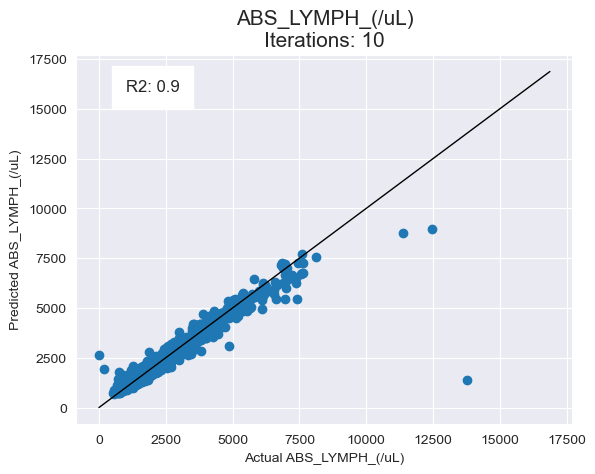

                                           Feature Id  Importances
0                                          WBC_(K/uL)    39.511273
1                                     LYMPHOCYTES_(%)    37.303663
2                                            NEUT_(%)    21.962581
3                                    Hemocrit_(HCT_%)     0.290342
4                                                 SEX     0.217549
5                                           DOSE_(Gy)     0.184587
6                                       ABS_EOS_(/uL)     0.159172
7                                                 AGE     0.132920
8                                      ABS_NEUT_(/uL)     0.094026
9   Mean_corpuscular_hemaglobin_concentration_(MCH...     0.041923
10                                     ABS_BASO_(/uL)     0.036369
11                                    MONTHS AT IRRAD     0.022599
12                                           BASO_(%)     0.015205
13               Mean_corpuscular_hemaglobin_(MCH_pg)     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


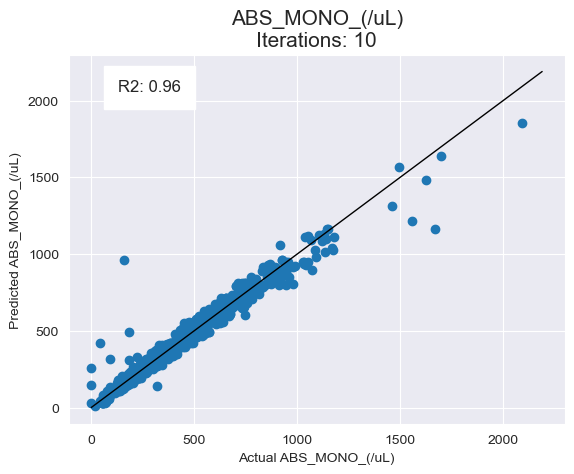

                                           Feature Id  Importances
0                                            MONO_(%)    53.598434
1                                          WBC_(K/uL)    45.075505
2                                    Hemocrit_(HCT_%)     0.459604
3                    Mean_corpuscular_volume_(MCV_fL)     0.369006
4                                      ABS_NEUT_(/uL)     0.149098
5                                PLATLET_COUNT_(K/uL)     0.096053
6                                     ABS_LYMPH_(/uL)     0.095758
7                                          RBC_(M/uL)     0.064804
8                                     MONTHS AT IRRAD     0.053204
9                                       ABS_EOS_(/uL)     0.026492
10                                    LYMPHOCYTES_(%)     0.012041
11                                            Species     0.000000
12                                              IRRAD     0.000000
13                                                SEX     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


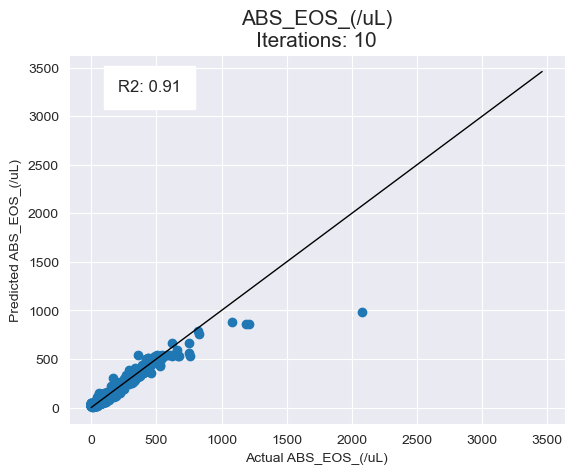

                                           Feature Id  Importances
0                                             EOS_(%)    78.945808
1                                          WBC_(K/uL)    19.930063
2                                                 AGE     0.354925
3                                      ABS_MONO_(/uL)     0.132217
4                                            NEUT_(%)     0.105537
5                                            MONO_(%)     0.105071
6                Mean_corpuscular_hemaglobin_(MCH_pg)     0.103342
7                                  MONTHS_SINCE_IRRAD     0.076943
8                                           DOSE_(Gy)     0.074580
9                                PLATLET_COUNT_(K/uL)     0.041411
10                                   DAYS_SINCE_IRRAD     0.036191
11                                   Hemocrit_(HCT_%)     0.031691
12                                     ABS_BASO_(/uL)     0.016161
13                                    LYMPHOCYTES_(%)     0.01

iteritems is deprecated and will be removed in a future version. Use .items instead.


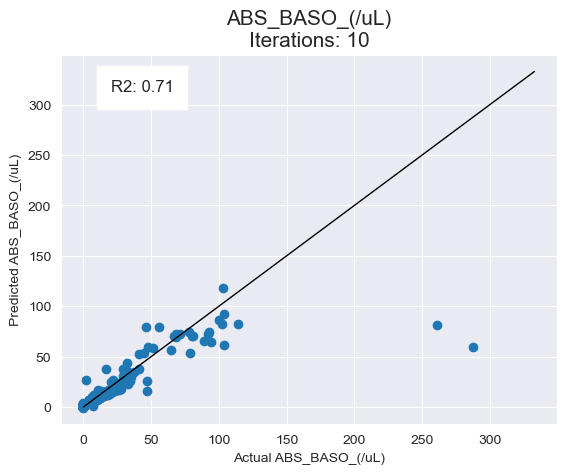

                                           Feature Id  Importances
0                                            BASO_(%)    70.914038
1                                          WBC_(K/uL)    13.392475
2                                       ABS_EOS_(/uL)     4.474926
3                                      ABS_NEUT_(/uL)     2.685479
4                                           DOSE_(Gy)     2.010322
5                                            NEUT_(%)     1.994954
6                                      ABS_MONO_(/uL)     1.002113
7                                    Hemocrit_(HCT_%)     0.853790
8                                                 AGE     0.755004
9                                PLATLET_COUNT_(K/uL)     0.479565
10                                    LYMPHOCYTES_(%)     0.396905
11                                 MONTHS_SINCE_IRRAD     0.313956
12                                         RBC_(M/uL)     0.181002
13                              Hemaglobin_(HGB_g/dL)     0.18

iteritems is deprecated and will be removed in a future version. Use .items instead.


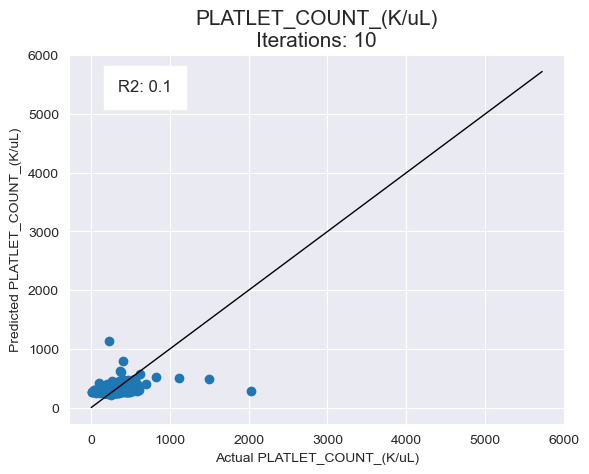

                                           Feature Id  Importances
0                                            MONO_(%)    18.296510
1                                                 AGE    12.102770
2                                      ABS_MONO_(/uL)     9.277655
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     7.431820
4                                     MONTHS AT IRRAD     6.992160
5                                  MONTHS_SINCE_IRRAD     6.249103
6                                     ABS_LYMPH_(/uL)     6.085484
7                               Hemaglobin_(HGB_g/dL)     5.648825
8                                       ABS_EOS_(/uL)     4.783021
9                                           DOSE_(Gy)     4.766630
10                                     ABS_NEUT_(/uL)     3.656538
11                   Mean_corpuscular_volume_(MCV_fL)     3.382395
12               Mean_corpuscular_hemaglobin_(MCH_pg)     2.273408
13                                         RBC_(M/uL)     1.81

In [113]:

cycle_feature_regression_predictions(cyclebio_df)

#4,3,3,3,3,4---

# OPTOMIZED REGRESSION CYCLER

In [54]:
def cycler_data_setup (df):

    ### Data Setup ###

    (train_df, test_df)= df, df 

    #data labeling
    
    global ylabel, y, X
    ylabel = columnName
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)

    #declare catagorical features
    global cat_features
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

    #put data into pool
    global pool
    pool = Pool(data=X, label=y, cat_features=cat_features)

    #train tesr split
    #test_size = float(input('Test Size'))
    test_size = 0.3
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data

    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )


In [55]:
def cycler_plotter (model, X_validation, y_validation, y):
        ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )

    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    #plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(ylabel + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )

    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin


    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    

    plt.show() 

    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )

    print(feat)
    

In [56]:
def cycler_objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        #"iterations" : trial.suggest_int("iterations", 1, 100000), - makes too long/comp really doesn't like it
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostRegressor(**param)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_validation, y_validation)], verbose=0, early_stopping_rounds=100)

    global a, a_df
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    accuracy = r2_score(y_validation, a)
    return accuracy


In [59]:
def optomized_regression_cycler (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
        
    global cat_cols
    cat_cols = int(input('How many catagorical columns:'))
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']   
    
    global columnName, columnData
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            cycler_data_setup (df)
            
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(direction="maximize")
            study.optimize(cycler_objective, n_trials=50, timeout=600)
            trial = study.best_trial
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            
            model = CatBoostRegressor(**trial.params, iterations=1000,early_stopping_rounds=5)
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
            
            cycler_plotter (model, X_validation, y_validation, y)


How many catagorical columns: 4


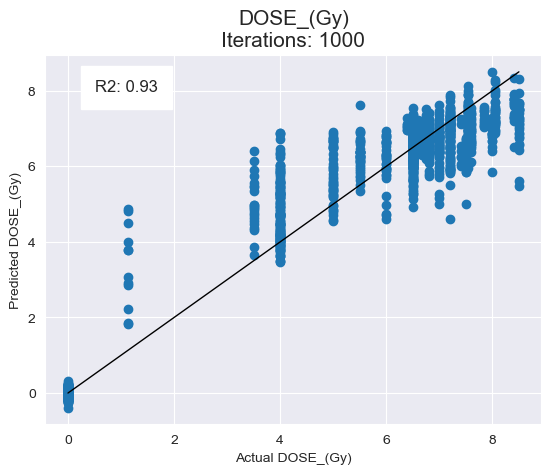

                                           Feature Id  Importances
0                                               IRRAD    32.047240
1                                  MONTHS_SINCE_IRRAD    15.816957
2                                    DAYS_SINCE_IRRAD    13.552900
3                                     MONTHS AT IRRAD    12.316151
4                                                 SEX     2.904959
5                                                 AGE     2.382602
6                Mean_corpuscular_hemaglobin_(MCH_pg)     1.965019
7                                          RBC_(M/uL)     1.766413
8                    Mean_corpuscular_volume_(MCV_fL)     1.765271
9                                    Hemocrit_(HCT_%)     1.691264
10                               PLATLET_COUNT_(K/uL)     1.495465
11                                            Species     1.352160
12                              Hemaglobin_(HGB_g/dL)     1.344153
13                                         WBC_(K/uL)     1.14

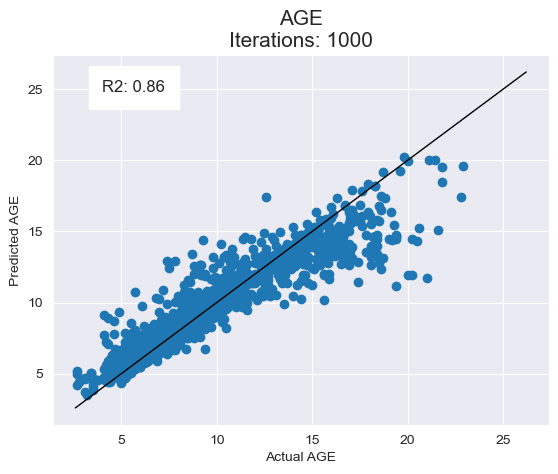

                                           Feature Id  Importances
0                                  MONTHS_SINCE_IRRAD    21.608724
1                                    DAYS_SINCE_IRRAD    12.745201
2                                     MONTHS AT IRRAD    12.112902
3                                           DOSE_(Gy)     8.858130
4                                             Species     8.594991
5                                               IRRAD     5.093982
6                                          RBC_(M/uL)     2.454239
7                                     ABS_LYMPH_(/uL)     2.239172
8                                            MONO_(%)     2.128203
9                               Hemaglobin_(HGB_g/dL)     2.014552
10                                                SEX     2.010432
11               Mean_corpuscular_hemaglobin_(MCH_pg)     1.936568
12                                         WBC_(K/uL)     1.783250
13                                   Hemocrit_(HCT_%)     1.74

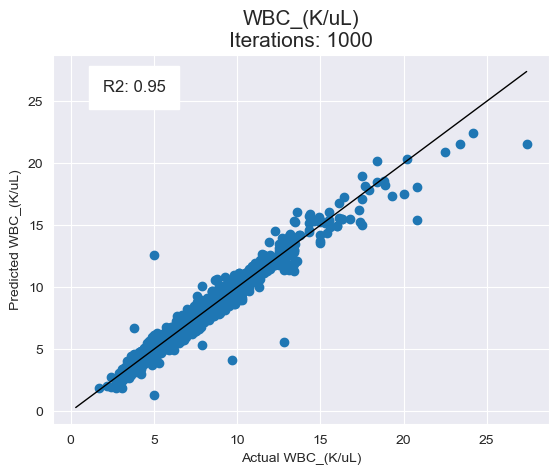

                                           Feature Id  Importances
0                                      ABS_NEUT_(/uL)    44.761673
1                                     ABS_LYMPH_(/uL)    19.647062
2                                      ABS_MONO_(/uL)     9.616278
3                                     LYMPHOCYTES_(%)     9.467311
4                                      ABS_BASO_(/uL)     3.037889
5                                            NEUT_(%)     2.911869
6                                            MONO_(%)     2.799282
7                                       ABS_EOS_(/uL)     1.140513
8                                           DOSE_(Gy)     1.037954
9                                            BASO_(%)     0.802193
10                                         RBC_(M/uL)     0.782919
11                                                AGE     0.515538
12                               PLATLET_COUNT_(K/uL)     0.512105
13                                   DAYS_SINCE_IRRAD     0.44

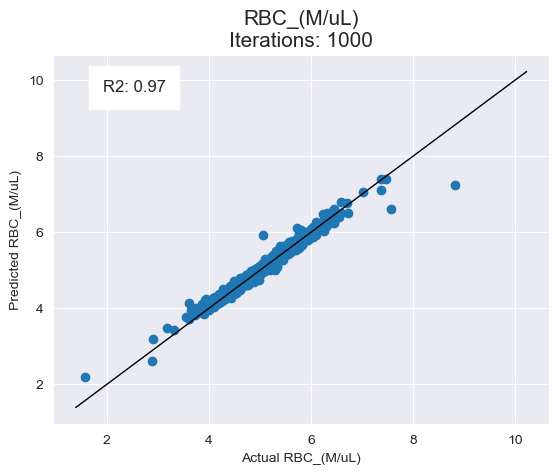

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    33.864438
1                                    Hemocrit_(HCT_%)    31.588582
2                    Mean_corpuscular_volume_(MCV_fL)    11.247997
3                                             Species     7.535986
4                Mean_corpuscular_hemaglobin_(MCH_pg)     5.383728
5                                                 SEX     2.202515
6                                           DOSE_(Gy)     2.162287
7                                  MONTHS_SINCE_IRRAD     1.137683
8                                     LYMPHOCYTES_(%)     0.589180
9                                               IRRAD     0.521044
10                                    MONTHS AT IRRAD     0.469804
11  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.450670
12                                   DAYS_SINCE_IRRAD     0.406218
13                               PLATLET_COUNT_(K/uL)     0.36

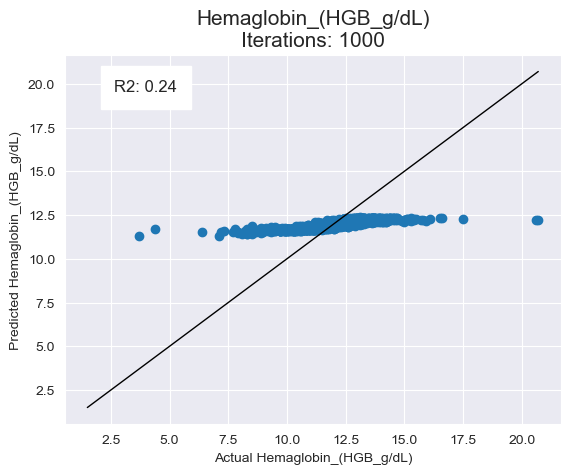

                                           Feature Id  Importances
0                                    Hemocrit_(HCT_%)    38.821656
1                                          RBC_(M/uL)    26.567550
2                Mean_corpuscular_hemaglobin_(MCH_pg)     8.726285
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     7.134257
4                                                 SEX     4.618837
5                                           DOSE_(Gy)     2.781745
6                    Mean_corpuscular_volume_(MCV_fL)     2.428910
7                                             Species     1.375382
8                                  MONTHS_SINCE_IRRAD     1.311743
9                                                 AGE     1.258321
10                                   DAYS_SINCE_IRRAD     0.922227
11                               PLATLET_COUNT_(K/uL)     0.817129
12                                    MONTHS AT IRRAD     0.542689
13                                           MONO_(%)     0.47

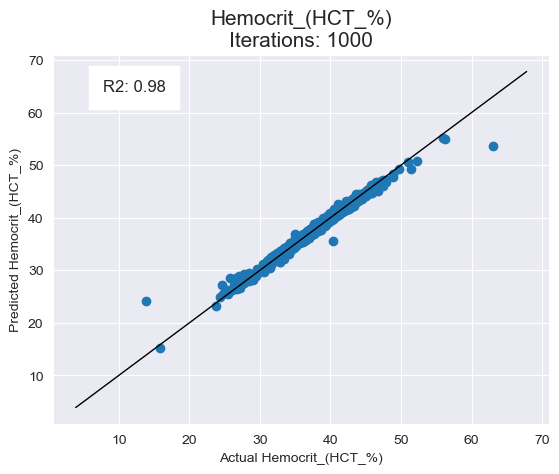

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    44.023562
1                                          RBC_(M/uL)    24.712688
2                    Mean_corpuscular_volume_(MCV_fL)     7.495778
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     4.340826
4                Mean_corpuscular_hemaglobin_(MCH_pg)     3.403052
5                                                 SEX     2.908498
6                                             Species     2.807711
7                                PLATLET_COUNT_(K/uL)     1.427274
8                                  MONTHS_SINCE_IRRAD     1.179024
9                                                 AGE     0.890244
10                                              IRRAD     0.888833
11                                               TYPE     0.788585
12                                          DOSE_(Gy)     0.695253
13                                   DAYS_SINCE_IRRAD     0.63

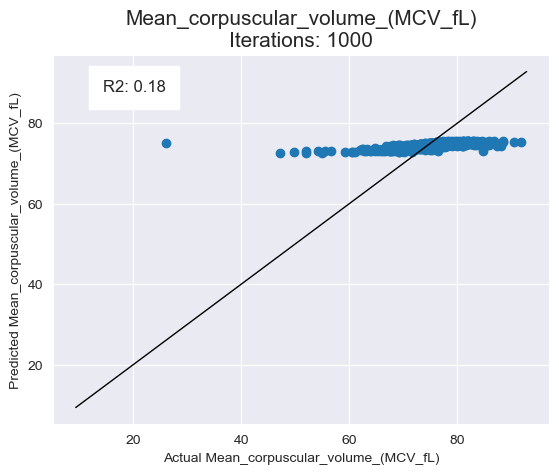

                                           Feature Id  Importances
0                Mean_corpuscular_hemaglobin_(MCH_pg)    42.471051
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    15.494899
2                                          RBC_(M/uL)    12.205053
3                               Hemaglobin_(HGB_g/dL)    11.874124
4                                    Hemocrit_(HCT_%)     8.177320
5                                           DOSE_(Gy)     1.806106
6                                                TYPE     1.553433
7                                                 SEX     0.886955
8                                                 AGE     0.846637
9                                     ABS_LYMPH_(/uL)     0.593416
10                                     ABS_MONO_(/uL)     0.441760
11                                    MONTHS AT IRRAD     0.438872
12                                            Species     0.424961
13                                   DAYS_SINCE_IRRAD     0.35

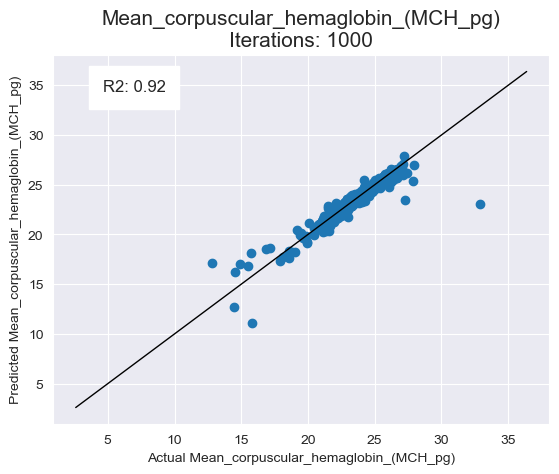

                                           Feature Id  Importances
0                    Mean_corpuscular_volume_(MCV_fL)    24.095269
1                               Hemaglobin_(HGB_g/dL)    18.459451
2   Mean_corpuscular_hemaglobin_concentration_(MCH...    15.884922
3                                          RBC_(M/uL)    14.952296
4                                    Hemocrit_(HCT_%)     9.363744
5                                                 SEX     2.055028
6                                PLATLET_COUNT_(K/uL)     1.701169
7                                           DOSE_(Gy)     1.600727
8                                                 AGE     1.592727
9                                      ABS_MONO_(/uL)     1.375009
10                                    MONTHS AT IRRAD     0.870331
11                                      ABS_EOS_(/uL)     0.849834
12                                           NEUT_(%)     0.829384
13                                            EOS_(%)     0.74

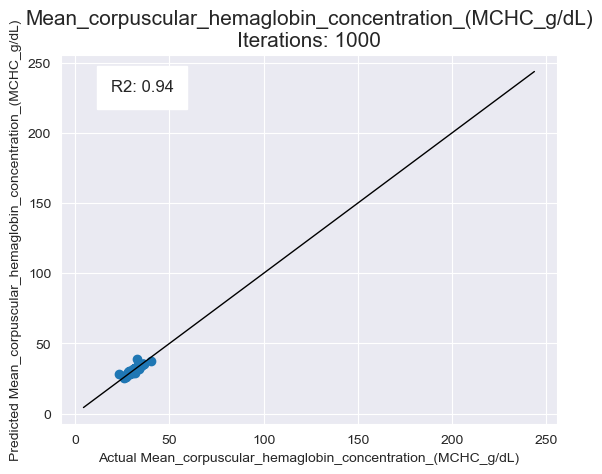

                              Feature Id  Importances
0       Mean_corpuscular_volume_(MCV_fL)    33.987817
1   Mean_corpuscular_hemaglobin_(MCH_pg)    30.534443
2                  Hemaglobin_(HGB_g/dL)    13.971371
3                                   TYPE     3.429535
4                        ABS_LYMPH_(/uL)     2.467622
5                       Hemocrit_(HCT_%)     2.389274
6                             RBC_(M/uL)     2.377387
7                         ABS_MONO_(/uL)     2.286787
8                                    AGE     1.126516
9                              DOSE_(Gy)     0.957138
10                              MONO_(%)     0.914424
11                              BASO_(%)     0.767074
12                               Species     0.697180
13                               EOS_(%)     0.688750
14                      DAYS_SINCE_IRRAD     0.488679
15                       MONTHS AT IRRAD     0.377714
16                    MONTHS_SINCE_IRRAD     0.343629
17                          

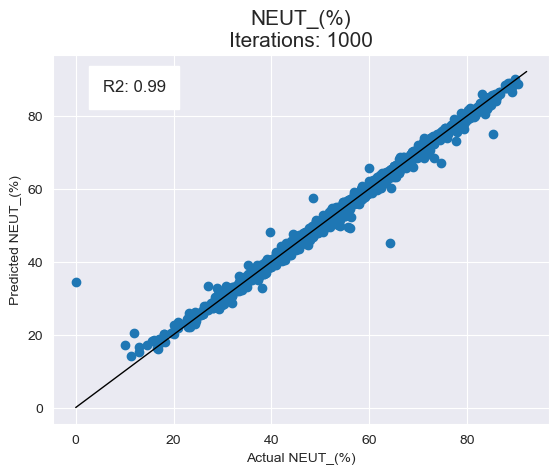

                                           Feature Id  Importances
0                                     LYMPHOCYTES_(%)    38.989546
1                                      ABS_NEUT_(/uL)    25.585614
2                                     ABS_LYMPH_(/uL)    14.849969
3                                       ABS_EOS_(/uL)     3.677237
4                                            MONO_(%)     3.402258
5                                             EOS_(%)     2.730558
6                                          WBC_(K/uL)     2.561149
7                                                 AGE     1.234531
8                                            BASO_(%)     0.868074
9                                      ABS_MONO_(/uL)     0.814287
10                               PLATLET_COUNT_(K/uL)     0.705057
11                                   DAYS_SINCE_IRRAD     0.605010
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.570314
13                                         RBC_(M/uL)     0.39

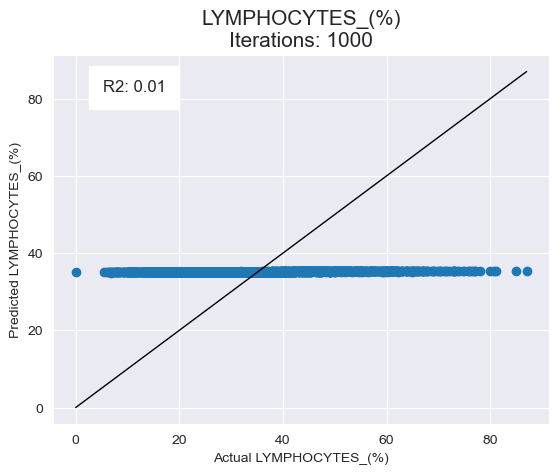

                                           Feature Id  Importances
0                                            NEUT_(%)    52.283078
1                                     ABS_LYMPH_(/uL)    17.867320
2                                      ABS_NEUT_(/uL)    15.828940
3                                          WBC_(K/uL)     3.306956
4                                       ABS_EOS_(/uL)     1.834104
5                                             EOS_(%)     1.531444
6                                                 AGE     1.253616
7                                            MONO_(%)     0.961916
8                                      ABS_MONO_(/uL)     0.894294
9                                             Species     0.413068
10                              Hemaglobin_(HGB_g/dL)     0.395749
11                                 MONTHS_SINCE_IRRAD     0.384725
12                                   DAYS_SINCE_IRRAD     0.377544
13                                         RBC_(M/uL)     0.30

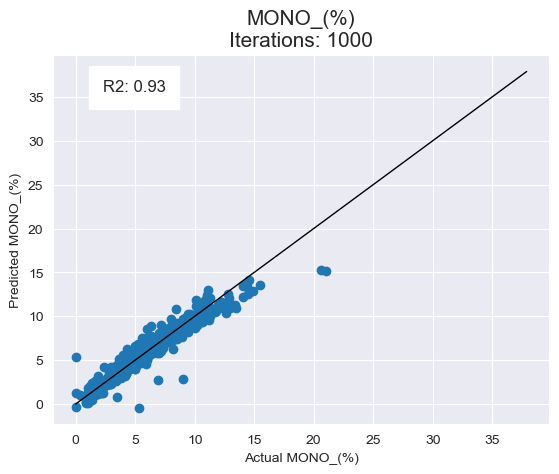

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    47.783932
1                                          WBC_(K/uL)     9.132059
2                                      ABS_NEUT_(/uL)     7.358467
3                                            NEUT_(%)     6.920084
4                                     ABS_LYMPH_(/uL)     5.871678
5                                                 AGE     2.954343
6                                     MONTHS AT IRRAD     2.441781
7                                             Species     1.885475
8                                     LYMPHOCYTES_(%)     1.837683
9                                  MONTHS_SINCE_IRRAD     1.786698
10                   Mean_corpuscular_volume_(MCV_fL)     1.328739
11  Mean_corpuscular_hemaglobin_concentration_(MCH...     1.090298
12                                      ABS_EOS_(/uL)     0.993233
13                                   Hemocrit_(HCT_%)     0.95

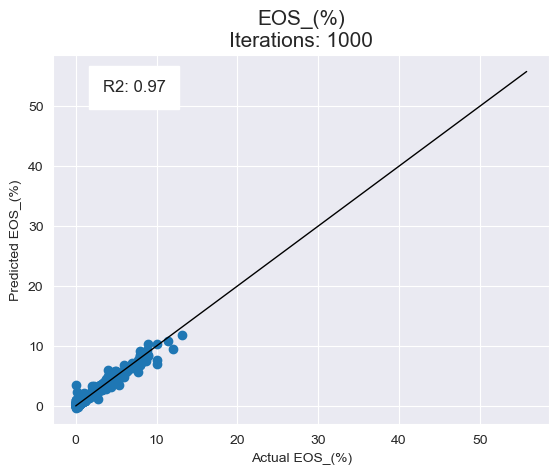

                                           Feature Id  Importances
0                                       ABS_EOS_(/uL)    61.559697
1                                      ABS_NEUT_(/uL)     6.735930
2                                            NEUT_(%)     5.656086
3                                     LYMPHOCYTES_(%)     4.291151
4                                     ABS_LYMPH_(/uL)     3.662329
5                                          WBC_(K/uL)     1.753627
6                                                 AGE     1.544883
7                Mean_corpuscular_hemaglobin_(MCH_pg)     1.252378
8                                           DOSE_(Gy)     1.174050
9                                      ABS_MONO_(/uL)     1.127860
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     1.041275
11                                 MONTHS_SINCE_IRRAD     1.035537
12                                   DAYS_SINCE_IRRAD     1.023249
13                               PLATLET_COUNT_(K/uL)     0.93

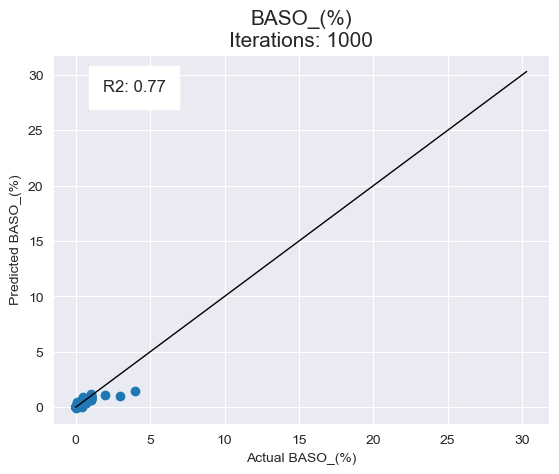

                                           Feature Id  Importances
0                                      ABS_NEUT_(/uL)    29.155951
1                Mean_corpuscular_hemaglobin_(MCH_pg)    20.703629
2                                       ABS_EOS_(/uL)    20.545197
3                                          WBC_(K/uL)     8.306694
4                                      ABS_BASO_(/uL)     8.221389
5                                           DOSE_(Gy)     5.508588
6                                     LYMPHOCYTES_(%)     4.194524
7                               Hemaglobin_(HGB_g/dL)     0.474316
8                                                 SEX     0.360450
9                                            NEUT_(%)     0.354154
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.340185
11                                    ABS_LYMPH_(/uL)     0.217897
12                                   Hemocrit_(HCT_%)     0.203536
13                                            EOS_(%)     0.19

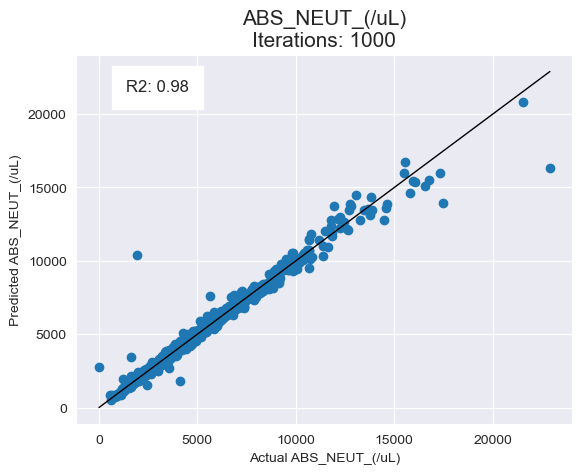

                                           Feature Id  Importances
0                                          WBC_(K/uL)    40.693095
1                                     LYMPHOCYTES_(%)    19.531423
2                                            NEUT_(%)    18.862409
3                                      ABS_MONO_(/uL)     5.610822
4                                            MONO_(%)     4.746482
5                                     ABS_LYMPH_(/uL)     2.449205
6                                             EOS_(%)     2.322437
7                                      ABS_BASO_(/uL)     1.760843
8                                            BASO_(%)     0.941724
9                                       ABS_EOS_(/uL)     0.517393
10                                          DOSE_(Gy)     0.477726
11                                   DAYS_SINCE_IRRAD     0.461986
12                                 MONTHS_SINCE_IRRAD     0.414402
13                                                SEX     0.23

In [ ]:
optomized_regression_cycler (cyclebio_df)

# Input your own data

In [ ]:
def my_health_api (li):
    vector = []
    vector2 = ['age','dose','days','months','age_at']
    age = float(input('Age (yr)'))
    vector.append(age)
    
    
    dose = float(input('Radiation dose (Gy)'))
    vector.append(dose)
    
    
    days = float(input('Days since exposure'))
    vector.append(days)
    
    
    months = float(input('Months since exposure'))
    vector.append(months)
    
    
    age_at = float(input('Age at exposure (mo)'))
    vector.append(months)
    

    
    df = pd.DataFrame(data=vector, columns=vector2)
    
    #print(a)
    print(df.head())

In [ ]:
vector = []
my_health_api (vector)

https://intellipaat.com/community/48721/how-to-take-2d-array-input-in-python 

In [ ]:
vector2 = ['age','dose','days','months','age_at']
print(vector
     )